# Notebook GUI for annotating extracted cells

Extracted cells will be at:  /data02/AZC/ROI-Finder/annotated_XRF/raw_cells
Please open directory for an xrf image and select any tif file from any channel.


<IPython.core.display.Javascript object>


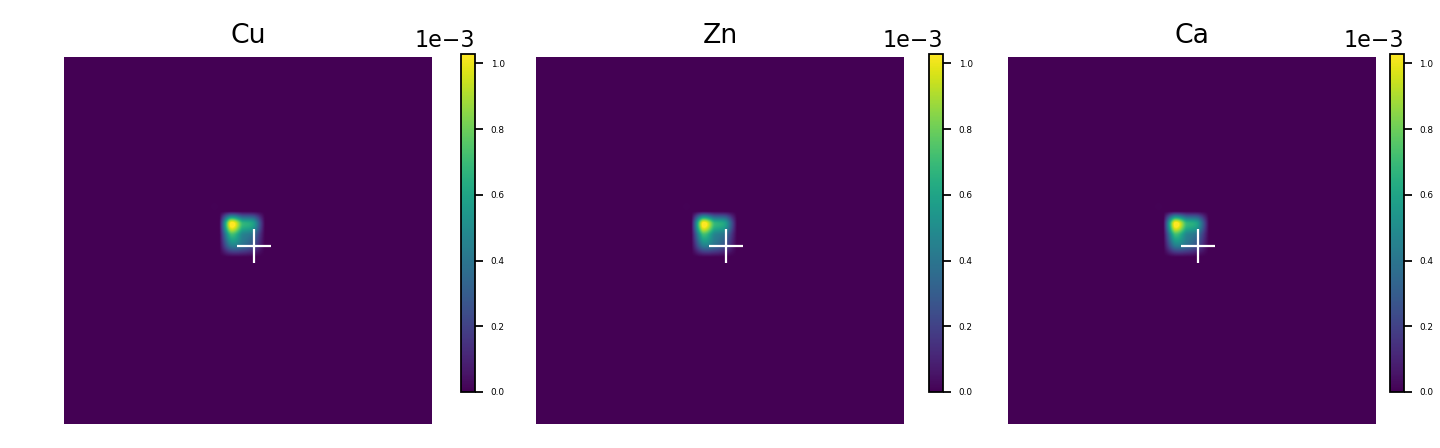

<IPython.core.display.Javascript object>


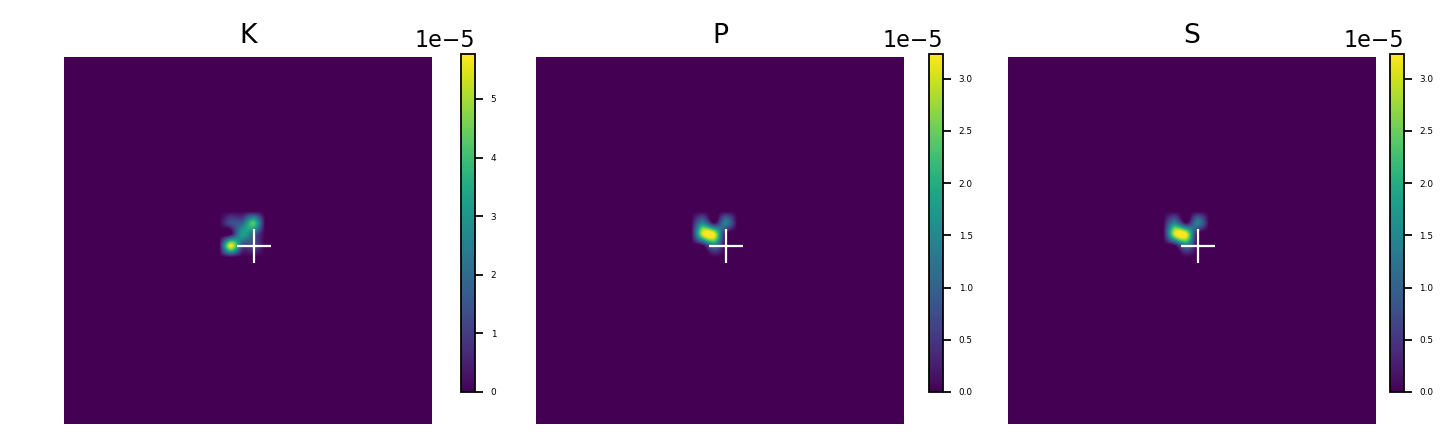

<IPython.core.display.Javascript object>


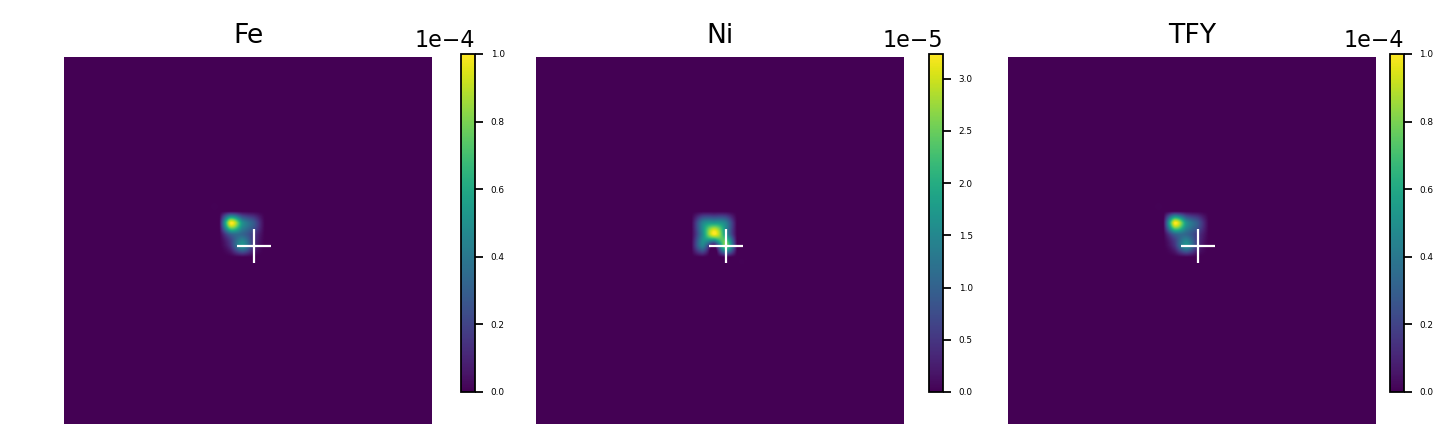

<IPython.core.display.Javascript object>


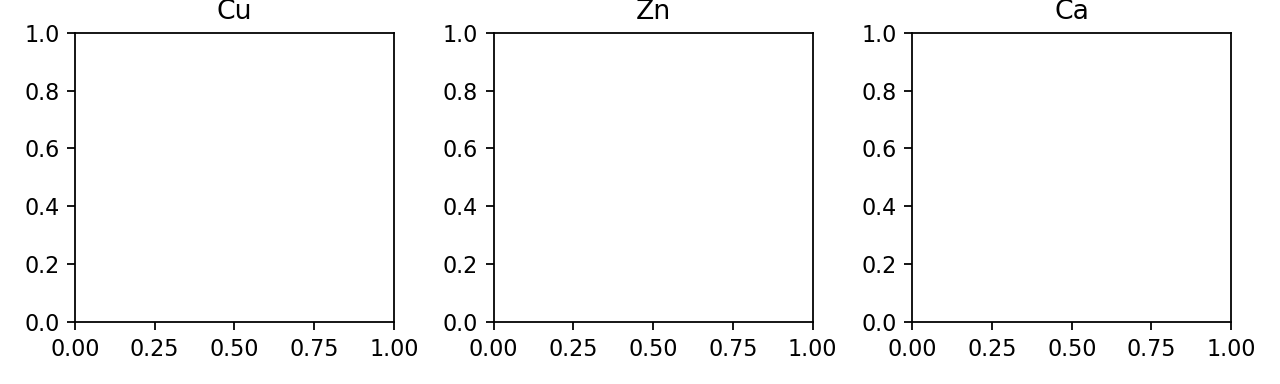

<IPython.core.display.Javascript object>


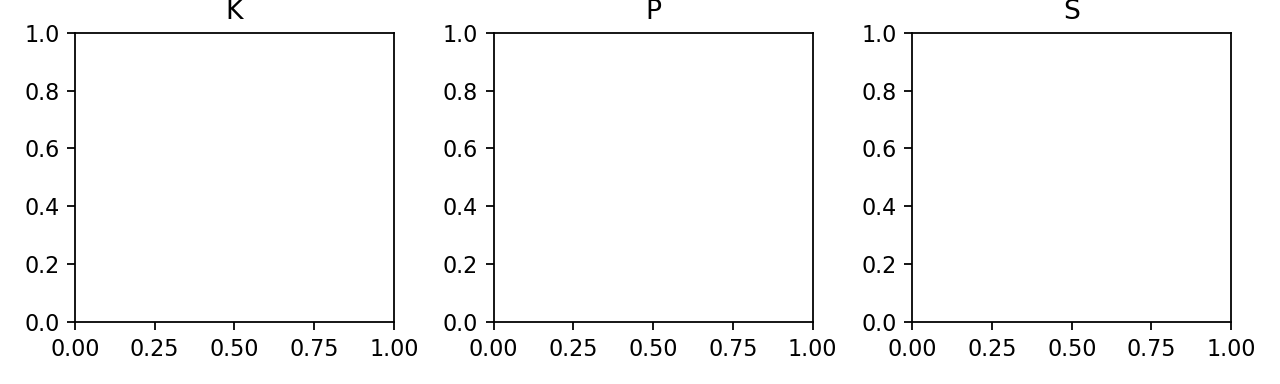

<IPython.core.display.Javascript object>


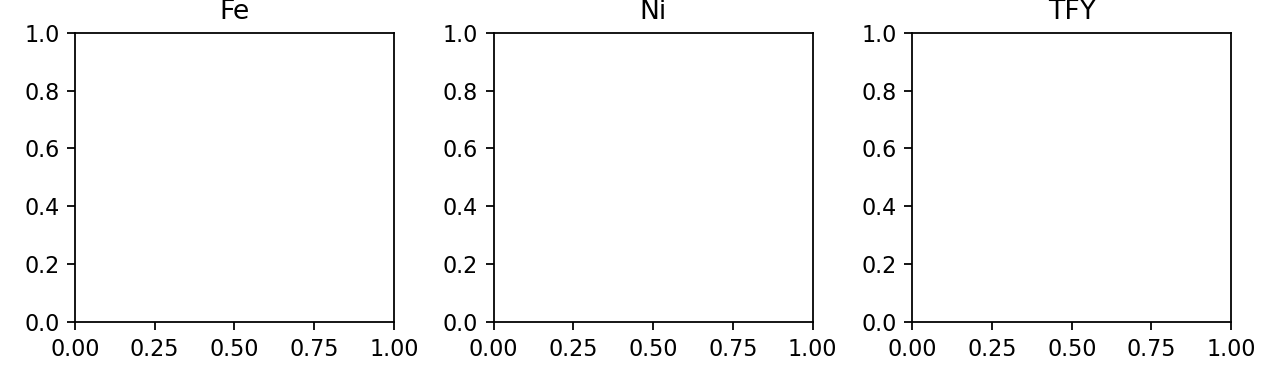

<IPython.core.display.Javascript object>


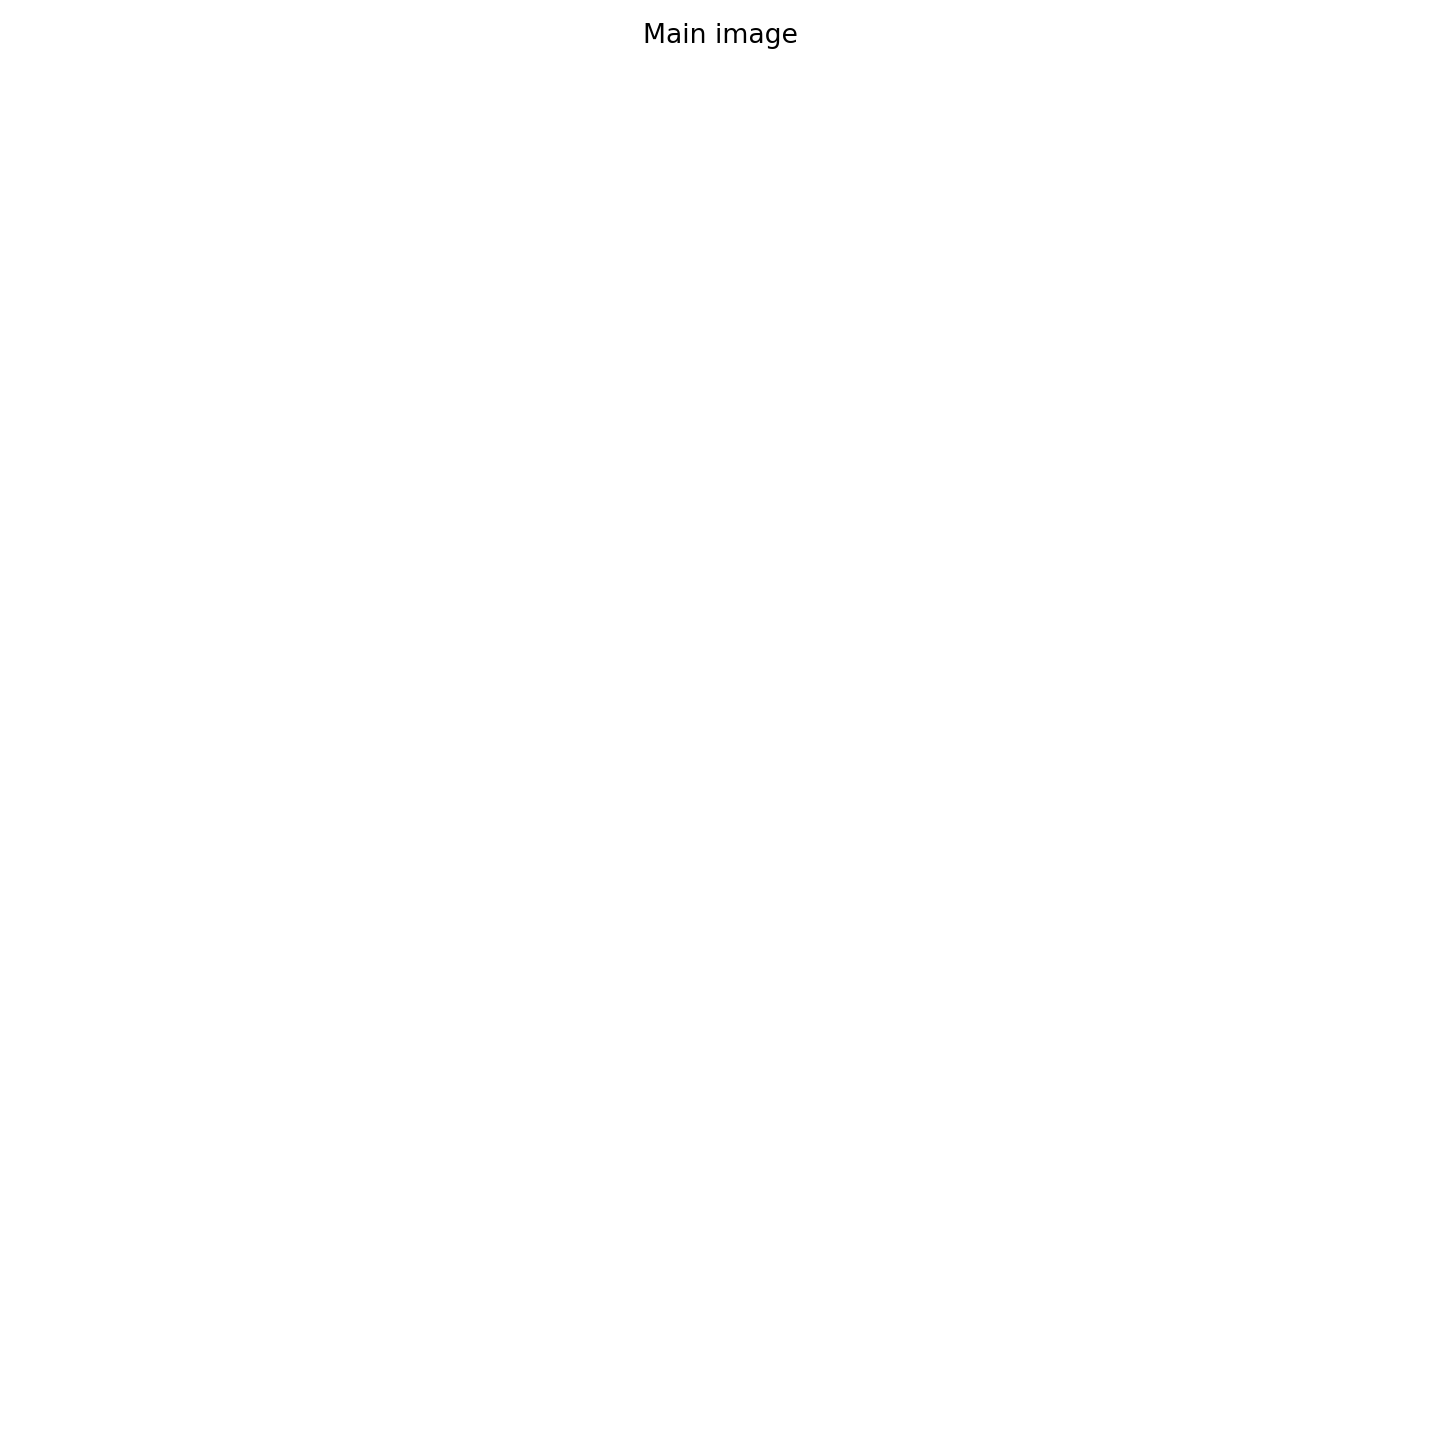

/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:695: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:696: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:697: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


NameError: name 'NORM_CH' is not defined

In [3]:
import beamtime_config_2022
from beamtime_config_2022 import *


%matplotlib notebook


def load_channels(obj):
    global base_xrf_img_dir, all_cells_Cu,all_cells_Zn,all_cells_Ca,all_cells_K,all_cells_P,all_cells_S,all_cells_Fe,all_cells_Ni,all_cells_TFY
    base_xrf_img_dir=os.path.split(fc.selected_path)[0]
    w_bin_info.disabled=False
    w_status.disabled=False
    
    slider.disabled=False
#     print('XRF image at : ',base_xrf_img_dir)
    a_Cu=os.path.join(base_xrf_img_dir,'Cu') + '/*.tif'
    a_Zn=os.path.join(base_xrf_img_dir,'Zn') + '/*.tif'
    a_Ca=os.path.join(base_xrf_img_dir,'Ca') + '/*.tif'
    a_K=os.path.join(base_xrf_img_dir,'K') + '/*.tif'
    a_P=os.path.join(base_xrf_img_dir,'P') + '/*.tif'
    a_S=os.path.join(base_xrf_img_dir,'S') + '/*.tif'
    a_Fe=os.path.join(base_xrf_img_dir,'Fe') + '/*.tif'
    a_Ni=os.path.join(base_xrf_img_dir,'Ni') + '/*.tif'
    a_TFY=os.path.join(base_xrf_img_dir,'TFY') + '/*.tif'
#     print(a_Cu)

    

    all_cells_Cu=sorted(glob.glob(a_Cu)) 
    all_cells_Zn=sorted(glob.glob(a_Zn)) 
    all_cells_Ca=sorted(glob.glob(a_Ca)) 
    all_cells_K=sorted(glob.glob(a_K)) 
    all_cells_P=sorted(glob.glob(a_P)) 
    all_cells_S=sorted(glob.glob(a_S)) 
    all_cells_Fe=sorted(glob.glob(a_Fe)) 
    all_cells_Ni=sorted(glob.glob(a_Ni)) 
    all_cells_TFY=sorted(glob.glob(a_TFY)) 
    
    w_status.value='Load cell images to view from :' + base_xrf_img_dir
    
    slider.max=len(all_cells_Cu)-1
    
    
    

def load_image(obj):
    global d, P
    global b_Cu, b_Zn, b_Ca, b_K, b_P, b_S, b_Fe, b_Ni, b_TFY
    global arr_Cu,arr_Zn,arr_Ca,arr_K,arr_P,arr_S,arr_Fe,arr_Ni,arr_TFY
    global stored_patch_h5_file_path
    idx=slider.value
    
    arr_Cu=np.array(all_cells_Cu)
    arr_Zn=np.array(all_cells_Zn)
    arr_Ca=np.array(all_cells_Ca)
    arr_K=np.array(all_cells_K)
    arr_P=np.array(all_cells_P)
    arr_S=np.array(all_cells_S)
    arr_Fe=np.array(all_cells_Fe)
    arr_Ni=np.array(all_cells_Ni)
    arr_TFY=np.array(all_cells_TFY)
    
    b_Cu=tiff.imread(arr_Cu[idx])
    b_Zn=tiff.imread(arr_Zn[idx])
    b_Ca=tiff.imread(arr_Ca[idx])
    b_K=tiff.imread(arr_K[idx])
    b_P=tiff.imread(arr_P[idx])
    b_S=tiff.imread(arr_S[idx])
    b_Fe=tiff.imread(arr_Fe[idx])
    b_Ni=tiff.imread(arr_Ni[idx])
    b_TFY=tiff.imread(arr_Fe[idx])
    
    #Show info and status
    w_status.value='Use slider to select cells from the XRF image.\nUse buttons to accept, reject or discard cells in bins. \n opened channel files' + '\n' + str(arr_Cu[idx]) + '\n' + str(arr_Zn[idx])  + '\n' + str(arr_Ca[idx]) + '\n' + str(arr_K[idx]) + '\n' + str(arr_P[idx]) + '\n' + str(arr_S[idx])
    xrf_file_key=os.path.split(arr_Cu[slider.value])[1].split('_')[0] + '_' +os.path.split(arr_Cu[slider.value])[1].split('_')[1] + '_' + os.path.split(arr_Cu[slider.value])[1].split('_')[2] + '_' + os.path.split(arr_Cu[slider.value])[1].split('_')[3]
    # shows the element and type of binary conversion

    
    
    #turn on for debug
#     print('opened channel files')
#     print(arr_Cu[idx])
#     print(arr_Zn[idx])
#     print(arr_Ca[idx])
#     print(arr_K[idx])
#     print(arr_P[idx])
#     print(arr_S[idx])
    
    
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    ax_2[0].clear()
    ax_2[1].clear()
    ax_2[2].clear()
    ax_3[0].clear()
    ax_3[1].clear()
    ax_3[2].clear()
    
    #images have flipped x and y
    
    num_bins=10
    
    img1=ax[0].imshow(b_Cu.T, interpolation='spline16');
    img2=ax[1].imshow(b_Zn.T, interpolation='spline16');
    img3=ax[2].imshow(b_Ca.T, interpolation='spline16');
    
    img4=ax_2[0].imshow(b_K.T, interpolation='spline16');
    img5=ax_2[1].imshow(b_P.T, interpolation='spline16');
    img6=ax_2[2].imshow(b_S.T, interpolation='spline16');
    
    
    
    img7=ax_3[0].imshow(b_Fe.T, interpolation='spline16');
    img8=ax_3[1].imshow(b_Ni.T, interpolation='spline16');
    img9=ax_3[2].imshow(b_TFY.T, interpolation='spline16');
    
    
    if w_hist.value == True:
        
        n_Cu, bins_Cu, boxes_Cu = ax_hist[0].hist(b_Cu, num_bins, density=True)
        n_Zn, bins_Zn, boxes_Zn = ax_hist[1].hist(b_Zn, num_bins, density=True)
        n_Ca, bins_Ca, boxes_Ca = ax_hist[2].hist(b_Ca, num_bins, density=True)
        n_K, bins_K, boxes_K = ax_hist_row_2[0].hist(b_K, num_bins, density=True)
        n_P, bins_P, boxes_P = ax_hist_row_2[1].hist(b_P, num_bins, density=True)
        n_S, bins_S, boxes_S = ax_hist_row_2[2].hist(b_S, num_bins, density=True)
        n_Fe, bins_Fe, boxes_Fe = ax_hist_row_3[0].hist(b_Fe, num_bins, density=True)
        n_Ni, bins_Ni, boxes_Ni = ax_hist_row_3[1].hist(b_Ni, num_bins, density=True)
        n_TFY, bins_TFY, boxes_TFY = ax_hist_row_3[2].hist(b_TFY, num_bins, density=True)

    
    ax_hist[0].set_title('Cu')
    ax_hist[1].set_title('Zn')
    ax_hist[2].set_title('Ca')
    ax_hist_row_2[0].set_title('K')
    ax_hist_row_2[1].set_title('P')
    ax_hist_row_2[2].set_title('S')
    ax_hist_row_3[0].set_title('Fe')
    ax_hist_row_3[1].set_title('Ni')
    ax_hist_row_3[2].set_title('TFY')
    
    
    
    fig.colorbar(img1, cax=cax1, orientation='vertical')
    fig.colorbar(img2, cax=cax2, orientation='vertical')
    fig.colorbar(img3, cax=cax3, orientation='vertical')
    
    
    fig_2.colorbar(img4, cax=cax1_2, orientation='vertical')
    fig_2.colorbar(img5, cax=cax2_2, orientation='vertical')
    fig_2.colorbar(img6, cax=cax3_2, orientation='vertical')
    
    fig_3.colorbar(img7, cax=cax1_3, orientation='vertical')
    fig_3.colorbar(img8, cax=cax2_3, orientation='vertical')
    fig_3.colorbar(img9, cax=cax3_3, orientation='vertical')
    
    fig.colorbar(img1, cax=cax1, orientation='vertical').ax.tick_params(labelsize=4)
    fig.colorbar(img2, cax=cax2, orientation='vertical').ax.tick_params(labelsize=4)
    fig.colorbar(img3, cax=cax3, orientation='vertical').ax.tick_params(labelsize=4)
    
    fig_2.colorbar(img4, cax=cax1_2, orientation='vertical').ax.tick_params(labelsize=4)
    fig_2.colorbar(img5, cax=cax2_2, orientation='vertical').ax.tick_params(labelsize=4)
    fig_2.colorbar(img6, cax=cax3_2, orientation='vertical').ax.tick_params(labelsize=4)
    
    fig_3.colorbar(img7, cax=cax1_3, orientation='vertical').ax.tick_params(labelsize=4)
    fig_3.colorbar(img8, cax=cax2_3, orientation='vertical').ax.tick_params(labelsize=4)
    fig_3.colorbar(img9, cax=cax3_3, orientation='vertical').ax.tick_params(labelsize=4)
    
    
    fig.colorbar(img1, cax=cax1, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    fig.colorbar(img2, cax=cax2, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    fig.colorbar(img3, cax=cax3, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    
    fig_2.colorbar(img4, cax=cax1_2, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    fig_2.colorbar(img5, cax=cax2_2, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    fig_2.colorbar(img6, cax=cax3_2, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    
    fig_3.colorbar(img7, cax=cax1_3, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    fig_3.colorbar(img8, cax=cax2_3, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    fig_3.colorbar(img9, cax=cax3_3, orientation='vertical').ax.ticklabel_format(style='sci', scilimits=(-2,2))
    
    
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    
    ax_2[0].axis('off')
    ax_2[1].axis('off')
    ax_2[2].axis('off')
    
    ax_3[0].axis('off')
    ax_3[1].axis('off')
    ax_3[2].axis('off')
    
    ax[0].set_title('Cu')
    ax[1].set_title('Zn')
    ax[2].set_title('Ca')
    
    ax_2[0].set_title('K')
    ax_2[1].set_title('P')
    ax_2[2].set_title('S')

    ax_3[0].set_title('Fe')
    ax_3[1].set_title('Ni')
    ax_3[2].set_title('TFY')


    fig.canvas.draw()
    fig_2.canvas.draw()
    fig_3.canvas.draw()


    fig.show()
    fig_2.show()
    fig_3.show()
    
    
    #14 is the half of mini_patch_size, so take one channel image and its sides
    ax[0].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    ax[1].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    ax[2].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    
    ax_2[0].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    ax_2[1].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    ax_2[2].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    
    
    ax_3[0].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    ax_3[1].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    ax_3[2].plot(b_Cu.shape[0]/2, b_Cu.shape[0]/2, 'w+', markersize=CROSS_HAIR_SIZE)
    
    
    
    # open main .h5 file and mark cross-hair there
    
    #load and plot original image first
    

    stored_main_h5_file=os.path.split(base_xrf_img_dir+os.path.split(fc.selected_filename)[0])[1] + '.h5'# filename of stored .h5 xrf_image

    stored_main_h5_file_path = os.path.join(base_xrf_img_dir+os.path.split(fc.selected_filename)[0],stored_main_h5_file) #path to stored main .h5 file


    norm_ch = NORM_CH
    value_offset=VALUE_OFFSET
    xrfdata = collections.defaultdict(list)


    with h5py.File(stored_main_h5_file_path, 'r') as dat:
            groups= list(dat.keys())
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
            xrf = dat['MAPS/XRF_roi'][:]
            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
            norm = scaler_val[scaler_names.index(norm_ch)]
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(fc.selected_filename)
            xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
            xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
    xrfdata = pd.DataFrame(xrfdata)

    
    elms=[w_preview_elm.value] # Only TFY for now, read from element dropdown to see other channels
    for i, row in xrfdata.iterrows():
            sc = row['scan_num'][0:row['scan_num'].index('.')]
            for e in elms:
                d = row[e]

                d[np.isnan(d) | np.isinf(d)] = 0
                norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)    
                x_d,y_d=row['x_axis'], row['y_axis']

    
    
    w_bin_info.value='Key: '+ os.path.split(arr_Cu[slider.value])[1] + '\n' +'Bin. Elm.: '   + os.path.split(arr_Cu[slider.value])[1].split('_')[-2] + '\n' + 'Conv.: '+ os.path.split(arr_Cu[slider.value])[1].split('_')[-4] + '\n' + 'Total cell count = ' + str(len(all_cells_Cu)) 
    w_bin_info.value=w_bin_info.value + '\n' + 'Main image shape : ' + str(d.shape[0]) + 'x' + str(d.shape[1])

    
    
    
    ax_master.clear()      

#     img_master = ax_master.pcolormesh(x_d, y_d, d, shading = 'gouraud')
    img_master = ax_master.imshow(d.T)
    ax_master.axis('off')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*(x_d[1]-x_d[0]), "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax_master.add_artist(scalebar_master)
    ax_master.set_title('Main image Channel: ' + elms[0])

    # Now get cell centers by reading the patch data structure first then the centers for the corresponding patch
    
    #first get the path of the stored patch for corresponding binary conversion and conversion element
    #filename of the stored patch
    stored_patch_h5_file=os.path.split(base_xrf_img_dir+os.path.split(fc.selected_filename)[0])[1] + '_' + 'DEC' + '_' + 'Patches' + '_' + os.path.split(arr_Cu[slider.value])[1].split('_')[-4] + '_' + 'BEC' + '_' + os.path.split(arr_Cu[slider.value])[1].split('_')[-2] + '.csv'
    #path to the stored patch


    stored_patch_h5_file_path= os.path.join(base_xrf_img_dir+os.path.split(fc.selected_filename)[0],stored_patch_h5_file) 


    stored_patch_h5_file_path
    
    #update status
    
    w_status.value=w_status.value+ '\n patches stored at: ' + stored_patch_h5_file_path
    
    
    #mark the currently viewed cells location on the main image channel
#     P = Patches2D(d.shape, initialize_by = "file", fpath=stored_patch_h5_file_path)
    #get the patch index needed for a cell from the filename
    center_in_main = pd.read_csv(stored_patch_h5_file_path, header=None).to_numpy()
    
    
    
    
    
    
    #b_Cu.shape[0]/2 is the half of crop_size or base_patch_width
    # we get centers from the patches2d data structure, but the bounding box requires corner points
    
    cell_bbox = patches.Rectangle((center_in_main[idx][0]-b_Cu.shape[0]/2, center_in_main[idx][1]-b_Cu.shape[0]/2), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
    ax_master.add_patch(cell_bbox)




    
    # OR PLOT cross-hair to mark location in main image
    ax_master.plot(center_in_main[idx][0], center_in_main[idx][1], 'w+', markersize=CROSS_HAIR_SIZE)
    


    
    return
    
def accept(obj):
    #accept codeblock
    accept_path=os.path.join(os.path.join(os.path.split(os.path.split(os.path.split(os.path.split(arr_Cu[slider.value])[0])[0])[0])[0], "accept"))
    xrf_image_tag=os.path.split(os.path.split(os.path.split(arr_Cu[slider.value])[0])[0])[1] 
    xrf_image_accepted_dir=os.path.join(accept_path,xrf_image_tag)
    

    is_xrf_image_accept_Exist = os.path.exists(xrf_image_accepted_dir)

    if not is_xrf_image_accept_Exist:
#         print('accepted, ' + xrf_image_tag + ' directory created')
        w_status.value='accepted, ' + xrf_image_tag + ' directory created'
        os.mkdir(xrf_image_accepted_dir)
    else:
#         print('accepted, ' + xrf_image_tag + ' directory exists!')
        w_status.value='accepted, ' + xrf_image_tag + ' directory exists!'



    is_accept_Cu_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'Cu'))  
    is_accept_Zn_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'Zn'))  
    is_accept_Ca_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'Ca'))  
    is_accept_K_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'K'))  
    is_accept_P_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'P'))  
    is_accept_S_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'S')) 
    is_accept_Fe_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'Fe'))
    is_accept_Ni_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'Ni'))
    is_accept_TFY_Exist = os.path.exists(os.path.join(xrf_image_accepted_dir,'Ni'))


    if not is_accept_Cu_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'Cu'))
    if not is_accept_Zn_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'Zn'))
    if not is_accept_Ca_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'Ca'))
    if not is_accept_K_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'K'))
    if not is_accept_P_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'P'))
    if not is_accept_S_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'S'))
    if not is_accept_Fe_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'Fe'))
    if not is_accept_Ni_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'Ni'))
    if not is_accept_TFY_Exist:
        os.mkdir(os.path.join(xrf_image_accepted_dir,'TFY'))


    copy(arr_Cu[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'Cu'),os.path.split(arr_Cu[slider.value])[1]) ); # savepath Cu channel

    copy(arr_Zn[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'Zn'),os.path.split(arr_Zn[slider.value])[1]) ); # savepath Zn channel


    copy(arr_Ca[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'Ca'),os.path.split(arr_Ca[slider.value])[1]) ); # savepath Ca channel

    copy(arr_K[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'K'),os.path.split(arr_K[slider.value])[1]) ); # savepath K channel


    copy(arr_P[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'P'),os.path.split(arr_P[slider.value])[1]) ); # savepath P channel

    copy(arr_S[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'S'),os.path.split(arr_S[slider.value])[1]) ); # savepath S channel    

    copy(arr_Fe[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'Fe'),os.path.split(arr_S[slider.value])[1]) ); # savepath Fe channel
    
    copy(arr_Ni[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'Ni'),os.path.split(arr_S[slider.value])[1]) ); # savepath Ni channel
    
    copy(arr_TFY[slider.value], os.path.join(os.path.join(xrf_image_accepted_dir, 'TFY'),os.path.split(arr_S[slider.value])[1]) ); # savepath TFY channel
    
def reject(obj):
    #reject codeblock
    reject_path=os.path.join(os.path.join(os.path.split(os.path.split(os.path.split(os.path.split(arr_Cu[slider.value])[0])[0])[0])[0], "reject"))
    xrf_image_tag=os.path.split(os.path.split(os.path.split(arr_Cu[slider.value])[0])[0])[1] 
    xrf_image_rejected_dir=os.path.join(reject_path,xrf_image_tag)


    is_xrf_image_reject_Exist = os.path.exists(xrf_image_rejected_dir)

    if not is_xrf_image_reject_Exist:
#         print('rejected, ' + xrf_image_tag + ' directory created')
        w_status.value='rejected, ' + xrf_image_tag + ' directory created'
        os.mkdir(xrf_image_rejected_dir)
    else:
#         print('rejected, ' + xrf_image_tag + ' directory exists!')
        w_status.value='rejected, ' + xrf_image_tag + ' directory exists!'



    is_reject_Cu_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'Cu'))  
    is_reject_Zn_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'Zn'))  
    is_reject_Ca_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'Ca'))  
    is_reject_K_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'K'))  
    is_reject_P_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'P'))  
    is_reject_S_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'S'))  
    is_reject_Fe_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'Fe'))
    is_reject_Ni_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'Ni'))
    is_reject_TFY_Exist = os.path.exists(os.path.join(xrf_image_rejected_dir,'TFY'))
    


    if not is_reject_Cu_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'Cu'))
    if not is_reject_Zn_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'Zn'))
    if not is_reject_Ca_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'Ca'))
    if not is_reject_K_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'K'))
    if not is_reject_P_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'P'))
    if not is_reject_S_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'S'))
    if not is_reject_Fe_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'Fe'))
    if not is_reject_Ni_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'Ni'))
    if not is_reject_TFY_Exist:
        os.mkdir(os.path.join(xrf_image_rejected_dir,'TFY'))


    copy(arr_Cu[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'Cu'),os.path.split(arr_Cu[slider.value])[1])); # savepath Cu channel

    copy(arr_Zn[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'Zn'),os.path.split(arr_Zn[slider.value])[1])); # savepath Zn channel


    copy(arr_Ca[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'Ca'),os.path.split(arr_Ca[slider.value])[1])); # savepath Ca channel

    copy(arr_K[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'K'),os.path.split(arr_K[slider.value])[1]) ); # savepath K channel


    copy(arr_P[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'P'),os.path.split(arr_P[slider.value])[1]) ); # savepath P channel

    copy(arr_S[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'S'),os.path.split(arr_S[slider.value])[1]) ); # savepath S channel 
    
    copy(arr_Fe[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'Fe'),os.path.split(arr_S[slider.value])[1]) ); # savepath Fe channel        
    
    copy(arr_Ni[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'Ni'),os.path.split(arr_S[slider.value])[1]) ); # savepath Ni channel
    
    copy(arr_TFY[slider.value], os.path.join(os.path.join(xrf_image_rejected_dir, 'TFY'),os.path.split(arr_S[slider.value])[1]) ); # savepath TFY channel

    
    
def not_cell(obj):
    #not_cell codeblock
    not_cell_path=os.path.join(os.path.join(os.path.split(os.path.split(os.path.split(os.path.split(arr_Cu[slider.value])[0])[0])[0])[0], "not_cell"))
    xrf_image_tag=os.path.split(os.path.split(os.path.split(arr_Cu[slider.value])[0])[0])[1] 
    xrf_image_not_cell_dir=os.path.join(not_cell_path,xrf_image_tag)


    is_xrf_image_not_dir_Exist = os.path.exists(xrf_image_not_cell_dir)

    if not is_xrf_image_not_dir_Exist:
#         print('rejected, ' + xrf_image_tag + ' directory created')
        w_status.value='not_cell, ' + xrf_image_tag + ' directory created'
        os.mkdir(xrf_image_not_cell_dir)
    else:
#         print('rejected, ' + xrf_image_tag + ' directory exists!')
        w_status.value='not_cell, ' + xrf_image_tag + ' directory exists!'



    is_not_cell_Cu_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'Cu'))  
    is_not_cell_Zn_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'Zn'))  
    is_not_cell_Ca_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'Ca'))  
    is_not_cell_K_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'K'))  
    is_not_cell_P_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'P'))  
    is_not_cell_S_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'S'))  
    is_not_cell_Fe_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'Fe'))
    is_not_cell_Ni_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'Ni'))
    is_not_cell_TFY_Exist = os.path.exists(os.path.join(xrf_image_not_cell_dir,'TFY'))
    


    if not is_not_cell_Cu_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'Cu'))
    if not is_not_cell_Zn_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'Zn'))
    if not is_not_cell_Ca_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'Ca'))
    if not is_not_cell_K_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'K'))
    if not is_not_cell_P_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'P'))
    if not is_not_cell_S_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'S'))
    if not is_not_cell_Fe_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'Fe'))
    if not is_not_cell_Ni_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'Ni'))
    if not is_not_cell_TFY_Exist:
        os.mkdir(os.path.join(xrf_image_not_cell_dir,'TFY'))


    copy(arr_Cu[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'Cu'),os.path.split(arr_Cu[slider.value])[1])); # savepath Cu channel

    copy(arr_Zn[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'Zn'),os.path.split(arr_Zn[slider.value])[1])); # savepath Zn channel


    copy(arr_Ca[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'Ca'),os.path.split(arr_Ca[slider.value])[1])); # savepath Ca channel

    copy(arr_K[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'K'),os.path.split(arr_K[slider.value])[1]) ); # savepath K channel


    copy(arr_P[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'P'),os.path.split(arr_P[slider.value])[1]) ); # savepath P channel

    copy(arr_S[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'S'),os.path.split(arr_S[slider.value])[1]) ); # savepath S channel 
    
    copy(arr_Fe[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'Fe'),os.path.split(arr_S[slider.value])[1]) ); # savepath Fe channel        
    
    copy(arr_Ni[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'Ni'),os.path.split(arr_S[slider.value])[1]) ); # savepath Ni channel
    
    copy(arr_TFY[slider.value], os.path.join(os.path.join(xrf_image_not_cell_dir, 'TFY'),os.path.split(arr_S[slider.value])[1]) ); # savepath TFY channel

    
# annot_dir='annotated_XRF'
base__dir_path=os.path.join(os.path.join(os.path.dirname(os.getcwd()),annot_dir), 'raw_cells')
print("Extracted cells will be at: ", base__dir_path)  
print('Please open directory for an xrf image and select any tif file from any channel.')
    
tiff_dir = base__dir_path
default_path = tiff_dir 
fc = FileChooser(default_path)
fc.default_filename = '.tif'


w_hist= widgets.Checkbox(
    value=False,
    description='Plot Histogram',
    layout=widgets.Layout(height="auto", width="auto"),
    disabled=False,
    indent=False
)


w_preview_elm = widgets.Dropdown(options=['Cu','Zn','Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'TFY'], description='Preview Element:', value='TFY' , style={'description_width': 'initial'}, disabled=False)

w_bin_info = widgets.Textarea(description='Info.:', 
                             value='File information' ,  
#                              style={'description_width': 'initial'},
                             layout=widgets.Layout(height="auto", width="auto"),
                             disabled=True)

w_status = widgets.Textarea(description='Status:', 
                             value='Status pane: \n Selected preview element will be used to mark locations of extracted cells ' ,  
#                              style={'description_width': 'initial'},
                             layout=widgets.Layout(height="auto", width="auto"),
                             disabled=True)

btn_fc = widgets.Button(description = "Load Channels")


btn_load_img = widgets.Button(description = "Load cell images")
btn_accept = widgets.Button(description = "Accept", disabled=False)
btn_reject = widgets.Button(description = "Reject", disabled=False)
btn_not_cell = widgets.Button(description = "Not a cell", disabled=False)

slider = widgets.IntSlider(min=0, max=100, step=1, continuous_update=True, disabled=True)




display(HBox(children = [btn_fc, fc]))
display(HBox(children = [w_hist]))
display(HBox(children = [w_preview_elm]))
display(HBox(children = [w_bin_info,w_status]))
display(HBox(children = [slider]))
display(HBox(children = [btn_load_img, btn_accept, btn_reject, btn_not_cell]))

global fig, ax, fig_2, ax_2 , fig_3, ax_3, fig_master, ax_master
global img1,img2,img3,img4,img5,img6

fig, ax = plt.subplots(1,3, figsize = FIGSIZE)
fig_2, ax_2 = plt.subplots(1,3, figsize = FIGSIZE)
fig_3, ax_3 = plt.subplots(1,3, figsize = FIGSIZE)




fig_hist, ax_hist = plt.subplots(1,3,figsize=SMALL_FIGSIZE)
fig_hist.tight_layout()

fig_hist_row_2, ax_hist_row_2 = plt.subplots(1,3,figsize=SMALL_FIGSIZE)
fig_hist_row_2.tight_layout()

fig_hist_row_3, ax_hist_row_3 = plt.subplots(1,3,figsize=SMALL_FIGSIZE)
fig_hist_row_3.tight_layout()


#play with the horizontal value to position the colorbars properly




cax1 = fig.add_axes(cbar_position1_annot)
cax2 = fig.add_axes(cbar_position2_annot)
cax3 = fig.add_axes(cbar_position3_annot)

cax1_2 = fig_2.add_axes(cbar_position1_annot)
cax2_2 = fig_2.add_axes(cbar_position2_annot)
cax3_2 = fig_2.add_axes(cbar_position3_annot)


cax1_3 = fig_3.add_axes(cbar_position1_annot)
cax2_3 = fig_3.add_axes(cbar_position2_annot)
cax3_3 = fig_3.add_axes(cbar_position3_annot)

# Turn on the axis value for debugging

cax1.axis('on')
cax2.axis('on')
cax3.axis('on')

cax1_2.axis('on')
cax2_2.axis('on')
cax3_2.axis('on')


cax1_3.axis('on')
cax2_3.axis('on')
cax3_3.axis('on')


ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax_2[0].axis('off')
ax_2[1].axis('off')
ax_2[2].axis('off')

ax_3[0].axis('off')
ax_3[1].axis('off')
ax_3[2].axis('off')

ax[0].set_title('Cu')
ax[1].set_title('Zn')
ax[2].set_title('Ca')

ax_2[0].set_title('K')
ax_2[1].set_title('P')
ax_2[2].set_title('S')

ax_3[0].set_title('Fe')
ax_3[1].set_title('Ni')
ax_3[2].set_title('TFY')




fig_master, ax_master = plt.subplots(1,1, figsize = (9,9))

ax_master.axis('off')
ax_master.set_title('Main image')

fig.tight_layout()
fig_2.tight_layout()
fig_3.tight_layout()
fig_master.tight_layout()

btn_fc.on_click(load_channels)
btn_load_img.on_click(load_image)
btn_accept.on_click(accept)
btn_reject.on_click(reject)
btn_not_cell.on_click(not_cell)




In [ ]:
#end!